## Loads mouse tracking data, plots it and annotates social interactions

- A notebook for exploring the data and project structure.
- Also enables choosing appropriate annotation values.
- Inspiration mainly taken from the notebooks: "00-identify-neurons" and "ratemap" from this project.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
import spatial_maps as sp
import head_direction as hd
import matplotlib.pyplot as plt

import exdir
%matplotlib inline

In [3]:
project_path = dp.project_path()
#project_path = '../../CA2prosjektmappe'
project = expipe.get_project(project_path)
actions = project.actions

In [4]:
def transform_coordinates(x, y, theta=90, **kwargs):
    """
    Transform tracking coordinates to align with physical coordinates
    For this project (CA2 MEC): rotate recorded coordinates 90 degrees, 
    followed by a shift to make values positive afterwards.
    """
    # rotate x,y coordinates 90 degrees using a 2D rotation matrix transform
    theta = np.radians(theta)
    r = np.array(( (np.cos(theta), -np.sin(theta)),
                   (np.sin(theta),  np.cos(theta)) ))
    coords = r @ np.array([x,y])
    # shift new x-coordinates to be positive
    coords -= np.array([[-1],[0]])
    return coords

def corner_masks(x, y, margin=0.4, **kwargs):
    """
    Find corner and center of box masks.
    """
    assert margin < 0.5 and margin > 0, "OBS! Margin must be positive and max half the box size, i.e. 0.5 OBS!"
    
    # center x and y coordinates
    x = x - 0.5
    y = y - 0.5
    pos = np.array([x, y]).T
    
    # create cardinal basis vectors
    ex, ey = np.arange(2), np.arange(2)[::-1]
    
    # create corner vectors: TR, TL, BL and BR, respectively
    corners = np.array([ex+ey, -ex+ey, -ex-ey, ex-ey])
    
    corner_masks = np.zeros((len(x), 5),dtype=bool)
    for i, corner in enumerate(corners):
        # find which quadrant positions are in, and if they are within the
        # box margins. The intersection gives the grand mask.
        quadrant_mask = ((pos * corner) > 0).all(axis=-1)
        margin_mask = (np.abs(pos) > (np.ones(2) * (0.5 - margin))).all(axis=-1)
        corner_masks[:,i] = quadrant_mask & margin_mask
    
    # inverse of union over corner masks
    corner_masks[:,-1] = ~np.array(corner_masks).any(axis=-1)
    return corner_masks

def social_label(action_str):
    """
    socializing can happen at either of the four corners of the box (space).
    there are four types of socializing: nobox (-1) empty (0), familiar (1) or novel (2).
    this gives a 4d-vector with four possible categories each.
    """
    
    def social_category(str1, str2):
        """ helper function """
        if str1 == 'nobox':
            return -1
        if str2 == 'e':
            return 0
        if str2 == 'f':
            return 1
        if str2 == 'n':
            return 2
    
    tags = project.require_action(action_str).attributes['tags']
    social_types = {'s': np.zeros(4), 'o': np.zeros(4)}
    for tag in tags:
        if not 'corner' in tag:
            continue
        stag = tag.split('_')[1:]
        # TR, TL, BL and BR, respectively
        if stag[1] == 'tr':
            social_types[stag[0]][0] = social_category(*stag[-2:])
        elif stag[1] == 'tl':
            social_types[stag[0]][1] = social_category(*stag[-2:])
        elif stag[1] == 'bl':
            social_types[stag[0]][2] = social_category(*stag[-2:])
        elif stag[1] == 'br':
            social_types[stag[0]][3] = social_category(*stag[-2:])
    
    return social_types

### Get tracking information

In [5]:
# choose an action
action_id = '001-280721-1'#'002-121220-2' 
action = actions[action_id]
print(action.attributes)
print(action.id, action.type)

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02 #0.01
smoothing = 0.03 #0.05
baseline_duration = None  #600

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=baseline_duration,
)

# common values for all units == faster calculations
x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
a, at = map(data_loader.head_direction(action_id).get, ['a', 't'])
# we only use t2 to check that it is the same as t.
print("Inconsistency in tracking data between head direction and tracking, {}".format(np.sum(t==at)/t.shape[0]))
# transform according to box-setup
x, y = transform_coordinates(x, y)

{'registered': '2021-08-16T11:38:06', 'datetime': '2021-07-28T18:47:26', 'type': 'Recording', 'tags': ['open-ephys', 'trial_id_t1', 'mec', 'social_1', 'corner_s_tl_nobox_e', 'corner_s_tr_box_e', 'corner_s_bl_box_e', 'corner_s_br_nobox_e'], 'entities': ['001'], 'users': ['maria'], 'location': 'ibv', 'data': {'main': 'actions\\001-280721-1\\data\\main.exdir'}}
001-280721-1 Recording
Inconsistency in tracking data between head direction and tracking, 0.0


/home/vemundss/anaconda3/envs/ca2mec/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Choose time-interval

In [6]:
t_start,t_stop = 0.0, None # default: None, None => include entire recording
# Choose tracking data time interval (IN SECONDS :D)
if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]
    a = a[mask] # also mask head-directions

### Define social zones

In [7]:
social_types = social_label(action_id)['s']
box_locations = ~(social_types== -1) # True where there is 'box', false on 'nobox'
box_idx_masks = np.append(box_locations, False)
cms = corner_masks(x=x, y=y, margin=0.4)
sm1,sm2 = cms[:,box_idx_masks].T
nsm = np.sum(cms[:,~box_idx_masks], axis=-1).astype(bool) # union of rest of space

### Visualise tracking and socializing

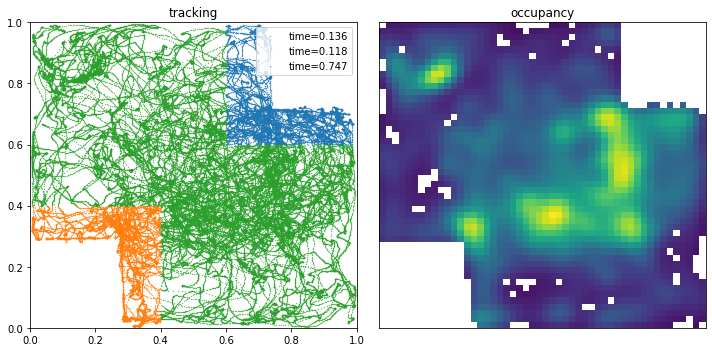

In [8]:
# calculate relative time spent in different parts of box
times = list(map(lambda x: np.sum(x), iter((sm1, sm2, nsm))))
fraction_times = np.around(np.array(times) / len(t), 3)

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
coords = np.stack([x,y],axis=-1)
axs[0].plot(*coords[sm1].T, 'o', markersize=0.3, label='time={}'.format(fraction_times[0]))
axs[0].plot(*coords[sm2].T, 'o', markersize=0.3, label='time={}'.format(fraction_times[1]))
axs[0].plot(*coords[nsm].T, 'o', markersize=0.3, label='time={}'.format(fraction_times[2]))
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_title('tracking')

spatial_map = sp.SpatialMap(x, y, t, spike_times=np.array([]), box_size=1.0, bin_size=bin_size)
occupancy_map = spatial_map.occupancy_map(smoothing=smoothing, mask_zero_occupancy=True)
#occupancy_map = np.rot90(occupancy_map)
axs[1].imshow(occupancy_map.T, vmin=0, aspect="auto", origin='lower')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('occupancy')

plt.tight_layout()
# default is Downloads folder, but can use any folder :) 
#plt.savefig("/Users/sarahht/Downloads/denne.png") #evt .pdf

### Visualise head direction and different zones

IndexError: boolean index did not match indexed array along dimension 0; dimension is 120304 but corresponding boolean dimension is 121576

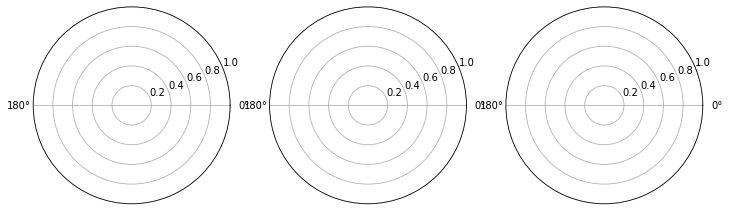

In [9]:
def head_direction_binned(a, bins=36, density=True):
    # circular histogram/bar-plot
    hist, bin_edges = np.histogram(a, bins=36, density=True)
    hist[np.isnan(hist)] = 0.0 # no data for this head-direction => height of bar = 0.0
    binwidth=(bin_edges[1]-bin_edges[0])
    bin_centers = bin_edges[1:] - binwidth/2
    return {'x': bin_centers, 'height': hist, 'width': binwidth}

# initialise plots
from matplotlib import gridspec
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(nrows=1,ncols=3)
axs = [fig.add_subplot(gs[0,i],projection='polar') for i in range(3)]

for ax in axs:
    ax.set_xticks([0, np.pi])
    #ax.set_rmax(2)
    #ax.set_rticks([0.25, 0.5, 0.75, 1.0])  # Less radial ticks
    #ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    #ax.grid(True)

# do plotting and invidual tuning
axs[0].bar(**head_direction_binned(a[sm1]),color='b')
axs[0].set_title('Top social zone HD')
axs[1].bar(**head_direction_binned(a[sm2]),color='b')
axs[1].set_title('Bottom social zone HD')
axs[2].bar(**head_direction_binned(a[nsm]),color='b')
axs[2].set_title('No social zone HD')
plt.tight_layout()

In [ ]:
def vonmises_kde(data, kappa=100, n_bins=100):
    # Kernel Density Estimation - continuous equivalent of a histogram
    from scipy.special import i0
    x = np.linspace(-np.pi, np.pi, n_bins)
    if len(data) == 0:
        return [], []
    # integrate vonmises kernels
    kde = np.exp(kappa * np.cos(x[:, None] - data[None, :])).sum(1) / (2 * np.pi * i0(kappa))
    kde /= np.trapz(kde, x=x)
    return x, kde

from matplotlib import gridspec
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(nrows=1,ncols=3)
axs = [fig.add_subplot(gs[0,i],projection='polar') for i in range(3)]
[ax.set_xticks([0, np.pi]) for ax in axs]

axs[0].plot(*vonmises_kde(a[sm1]),color='b')
axs[0].set_title('Top social zone HD')
axs[1].plot(*vonmises_kde(a[sm2]),color='b')
axs[1].set_title('Bottom social zone HD')
axs[2].plot(*vonmises_kde(a[nsm]),color='b')
axs[2].set_title('No social zone HD')
plt.tight_layout()